# 4 Sample Tests Power over Increasing Epsilon

These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

In [75]:
import sys, os
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend

sys.path.append(os.path.realpath('..'))
from benchmarks import power_4samp_epsweight
from hyppo.independence import MGC, Dcorr
from hyppo.sims import gaussian_4samp

In [2]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

## Brainstorming

In [34]:
from hyppo.ksample._utils import k_sample_transform
from sklearn.metrics import pairwise_distances

In [10]:
Xs = gaussian_4samp(100, epsilon=4)

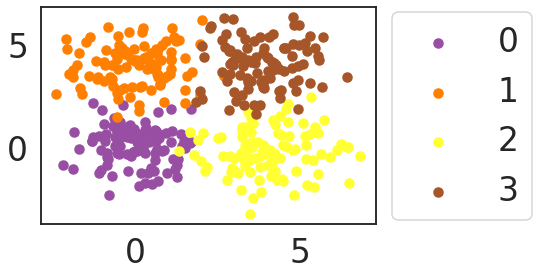

In [22]:
for i,X in enumerate(Xs):
    plt.scatter(X[:,0], X[:,1], label=i)
plt.legend(loc="upper left", bbox_to_anchor=(1,1.05))
plt.show()

In [38]:
def _center_distmat(distx, bias=False):  # pragma: no cover
    """Centers the distance matrices"""
    n = distx.shape[0]
    if bias:
        # use sum instead of mean because of numba restrictions
        exp_distx = (
            np.repeat(distx.sum(axis=0) / n, n).reshape(-1, n).T
            + np.repeat(distx.sum(axis=1) / n, n).reshape(-1, n)
            - (distx.sum() / (n * n))
        )
    else:
        exp_distx = (
            np.repeat((distx.sum(axis=0) / (n - 2)), n).reshape(-1, n).T
            + np.repeat((distx.sum(axis=1) / (n - 2)), n).reshape(-1, n)
            - distx.sum() / ((n - 1) * (n - 2))
        )
    cent_distx = distx - exp_distx
    if not bias:
        np.fill_diagonal(cent_distx, 0)
    return cent_distx

In [70]:
multiway = True
if multiway:
    ways = [[0,0], [0,1], [1,0], [1,1]]
    u, v = k_sample_transform(Xs, ways=ways)
else:
    u, v = k_sample_transform(Xs)

u_dist = _center_distmat(pairwise_distances(u, metric="euclidean"))
v_dist = _center_distmat(pairwise_distances(v, metric="euclidean"))# / 2)

[-1.21013211 -1.21013211  0.          0.20408145  0.20408145  0.20408145
  0.78986789  0.78986789]


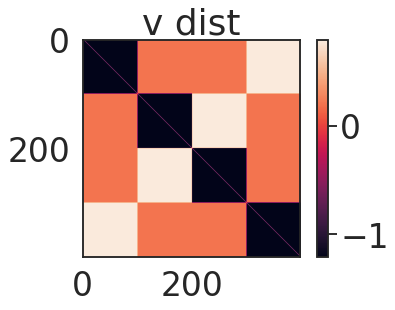

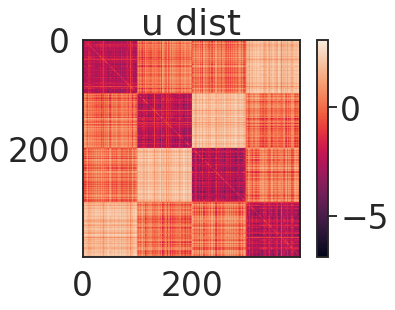

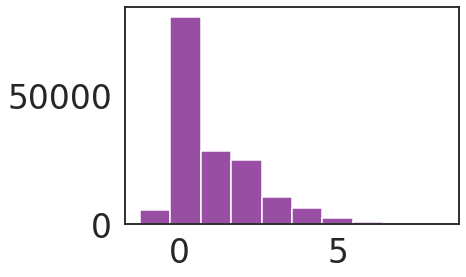

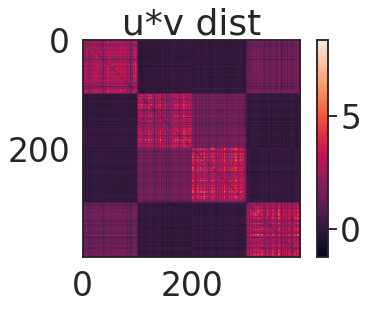

In [72]:
print(np.unique(v_dist))
plt.imshow(v_dist)
plt.colorbar()
plt.title('v dist')
plt.show()

plt.imshow(u_dist)
plt.colorbar()
plt.title('u dist')
plt.show()

plt.hist(np.concatenate(u_dist * v_dist))
plt.show()

plt.imshow(u_dist * v_dist)
plt.colorbar()
plt.title('u*v dist')
plt.show()

In [73]:
multiway = False
if multiway:
    ways = [[0,0], [0,1], [1,0], [1,1]]
    u, v = k_sample_transform(Xs, ways=ways)
else:
    u, v = k_sample_transform(Xs)

u_dist = _center_distmat(pairwise_distances(u, metric="euclidean"))
v_dist = _center_distmat(pairwise_distances(v, metric="euclidean"))# / 2)

[-1.06331847  0.          0.35089509]


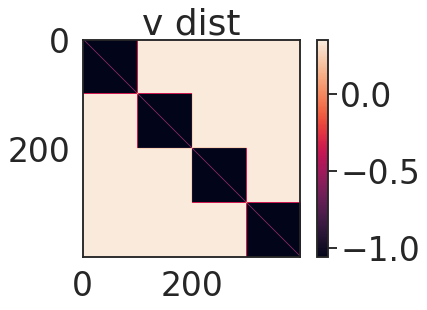

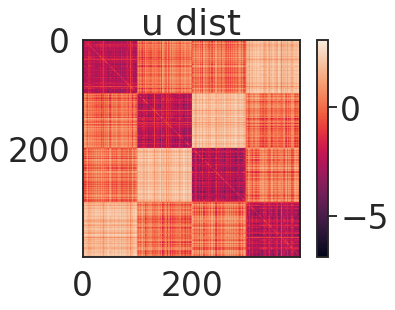

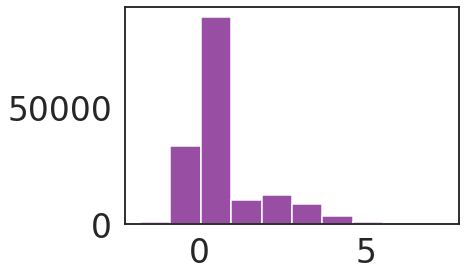

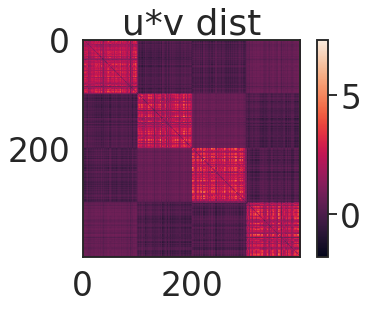

In [74]:
print(np.unique(v_dist))
plt.imshow(v_dist)
plt.colorbar()
plt.title('v dist')
plt.show()

plt.imshow(u_dist)
plt.colorbar()
plt.title('u dist')
plt.show()

plt.hist(np.concatenate(u_dist * v_dist))
plt.show()

plt.imshow(u_dist * v_dist)
plt.colorbar()
plt.title('u*v dist')
plt.show()

## Test

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the epsilons (distance from 0 for the center of each gaussian cluster) tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [77]:
MAX_EPSILON = 1
STEP_SIZE = 0.05
EPSILONS = np.arange(0, MAX_EPSILON + STEP_SIZE, STEP_SIZE)
WEIGHTS = EPSILONS
POWER_REPS = 5

In [76]:
tests = [
    Dcorr,
]

multiways = [
    True,
    False,
]

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [5]:
def estimate_power(test, multiway):
    est_power = np.array([
        np.mean([power_4samp_epsweight(test, epsilon=i, multiway=multiway, compute_distance=None)
            for _ in range(POWER_REPS)
        ]) 
        for i in EPSILONS
    ])
    np.savetxt('../benchmarks/4samp_vs_epsilon/{}_{}.csv'.format(multiway, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [6]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(test, multiway) for test in tests for multiway in multiways]
)

The following code loops over each saved independence test file and generates absolute power curves for each test and for each simulation modality.

In [78]:
FONTSIZE = 30

def plot_power():
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4,8))
    
    sim_title = [
        "Four Gaussians",
    ]
    ax = np.array([ax]).reshape((2,-1))
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            if i == 0:
                sims = gaussian_4samp(100, epsilon=4)
                
                sim_markers = [
                    "1",
                    "+",
                    "x",
                    '_',
                ]
                custom_color = [
                    "#d9d9d9",
                    "#969696",
                    "#525252",
                    "#747474",
                ]
                
                count = 0
                scatters = []
                for sim in sims:
                    x, y = np.hsplit(sim, 2)
                    scatters.append(col.scatter(x, y, marker=sim_markers[count], color=custom_color[count]))

                    #col.set_xlim(-5, 5)
                    #if case not in [2, 4]:
                    #    col.set_ylim(-5, 5)
                    col.set_xticks([])
                    col.set_yticks([])
                    col.set_title(sim_title[j], fontsize=FONTSIZE)
                    count += 1
            else:
                for test in tests:
                    for multiway in multiways:
                        power = np.genfromtxt(
                            '../benchmarks/4samp_vs_epsilon/{}_{}.csv'.format(multiway, test.__name__),
                            delimiter=','
                            )

                        custom_color = {
                            "Dcorr" : "#377eb8",
                            "Hsic" : "#4daf4a",
                            "MGC" : "#e41a1c",
                        }
                        if multiway:
                                label = f'Multiway {test.__name__}'
                        else:
                            label = f'{test.__name__}'
                        if test.__name__ in custom_color.keys():
                            if multiway:#test.__name__ == "MGC":
                                col.plot(EPSILONS, power, custom_color[test.__name__], label=label, lw=3)
                            else:
                                col.plot(EPSILONS, power, custom_color[test.__name__], label=label, ls='--', lw=2)
                        else:
                            col.plot(EPSILONS, power, label=label, lw=2)
                        col.tick_params(labelsize=FONTSIZE)
                        col.set_xticks([EPSILONS[0], EPSILONS[-1]])
                        col.set_ylim(0, 1.05)
                        col.set_yticks([])
                        if j == 0:
                            col.set_yticks([0, 1])
    
    fig.text(0.5, 0, 'Cluster Separation', ha='center', fontsize=FONTSIZE)
#     fig.text(0.75, 0, 'Increasing Weight', ha='center')
    fig.text(-0.05, 0.3, 'Power', va='center', rotation='vertical', fontsize=FONTSIZE)
    fig.text(-0.05, 0.7, 'Scatter Plots', va='center', rotation='vertical', fontsize=FONTSIZE)
    
    leg = plt.legend(bbox_to_anchor=(1.5, 0.45), bbox_transform=plt.gcf().transFigure,
                     ncol=1, loc='upper center', fontsize=FONTSIZE)
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.20)
    leg = Legend(fig, scatters, ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], loc='upper center', frameon=False, ncol=1,
                bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1.3, 0.9), fontsize=FONTSIZE)
    fig.add_artist(leg);
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3)
    plt.savefig('../benchmarks/figs/4samp_power_epsilon.pdf', transparent=True, bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (21,) and (11,)

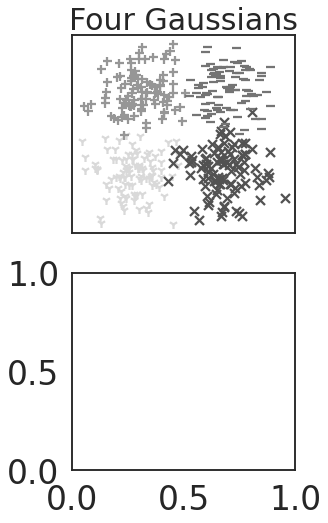

In [79]:
plot_power()